In [16]:
!pip install imagehash -q

In [17]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imagehash
from PIL import Image
from tqdm import tqdm

# Set visualization style
plt.style.use('ggplot')
print("All EDA libraries imported!")

All EDA libraries imported!


# Load data

In [18]:

path_train = '/kaggle/input/datasets/deadcardassian/pm25vision/train/metadata.csv'
path_test = '/kaggle/input/datasets/deadcardassian/pm25vision/test/metadata.csv'

# Load and merge
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)
df = pd.concat([df_train, df_test], ignore_index=True)

print(f"Total images for Global EDA: {len(df)}")

Total images for Global EDA: 11219


# Check Class Balance

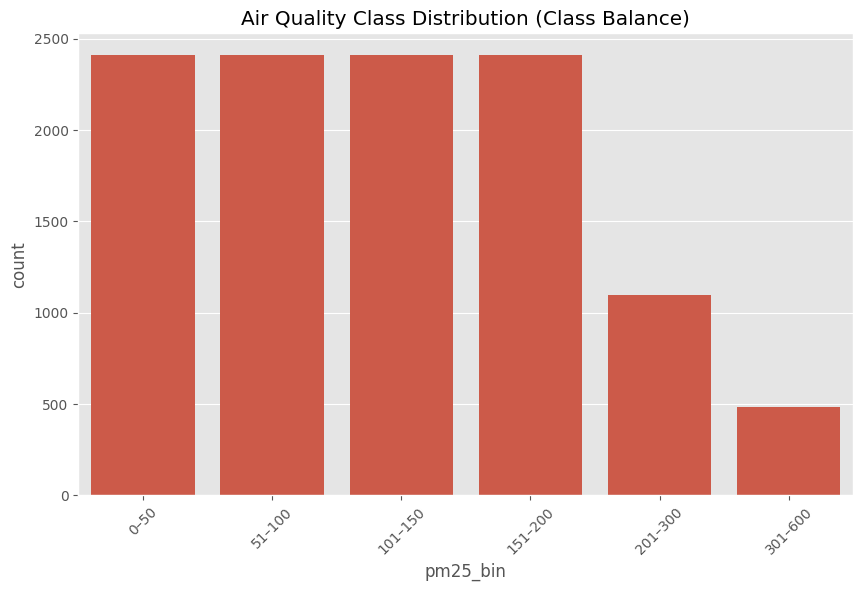

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='pm25_bin', order=df['pm25_bin'].value_counts().index)
plt.title('Air Quality Class Distribution (Class Balance)')
plt.xticks(rotation=45)
plt.show()

# Analyze Resolutions

In [20]:
def get_all_resolutions(df):
    results = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Scanning Resolutions"):
        path = f"/kaggle/input/datasets/deadcardassian/pm25vision/train/images/{row['filename']}"
        if not os.path.exists(path):
            path = f"/kaggle/input/datasets/deadcardassian/pm25vision/test/images/{row['filename']}"
            
        with Image.open(path) as img:
            w, h = img.size
            results.append({'width': w, 'height': h, 'aspect_ratio': w/h})
    return pd.DataFrame(results)

full_res_df = get_all_resolutions(df)
print("\nGlobal Resolution Statistics:")
print(full_res_df.describe())

Scanning Resolutions: 100%|██████████| 11219/11219 [01:43<00:00, 108.15it/s]


Global Resolution Statistics:
              width        height  aspect_ratio
count  11219.000000  11219.000000  11219.000000
mean    1023.217666    679.123095      1.540098
std       17.800644     99.711960      0.231033
min      320.000000    240.000000      0.667101
25%     1024.000000    576.000000      1.333333
50%     1024.000000    768.000000      1.333333
75%     1024.000000    768.000000      1.777778
max     1024.000000   1535.000000      2.939655


# Global Image Quality Analysis

Analyzing Quality: 100%|██████████| 11219/11219 [16:45<00:00, 11.16it/s]


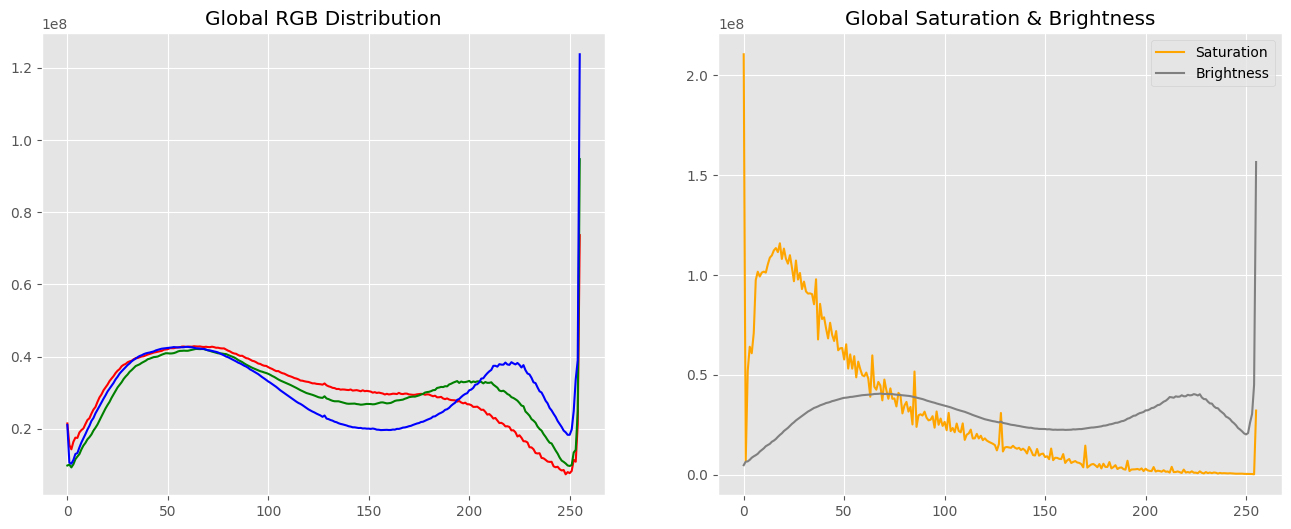

In [21]:
def analyze_all_images(df):
    all_stats = []
    hist_rgb = [np.zeros(256), np.zeros(256), np.zeros(256)]
    hist_hsv = [np.zeros(256), np.zeros(256), np.zeros(256)]

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing Quality"):
        path = f"/kaggle/input/datasets/deadcardassian/pm25vision/train/images/{row['filename']}"
        if not os.path.exists(path):
            path = f"/kaggle/input/datasets/deadcardassian/pm25vision/test/images/{row['filename']}"
            
        img_bgr = cv2.imread(path)
        if img_bgr is None: continue
            
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
        
        # Histograms
        for i in range(3):
            hist_rgb[i] += np.histogram(img_rgb[:,:,i], bins=256, range=(0,256))[0]
            hist_hsv[i] += np.histogram(img_hsv[:,:,i], bins=256, range=(0,256))[0]
        
        # Quality Metrics
        sharpness = cv2.Laplacian(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY), cv2.CV_64F).var()
        means = cv2.mean(img_rgb)[:3]
        wb_ratio = max(means) / (min(means) + 1e-6)
        
        all_stats.append({
            'class': row['pm25_bin'], 'sharpness': sharpness, 'wb_ratio': wb_ratio
        })
        
    return pd.DataFrame(all_stats), hist_rgb, hist_hsv

# Execute and visualize
full_stats_df, rgb_hists, hsv_hists = analyze_all_images(df)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(rgb_hists[0], color='red'); axes[0].plot(rgb_hists[1], color='green'); axes[0].plot(rgb_hists[2], color='blue')
axes[0].set_title("Global RGB Distribution")
axes[1].plot(hsv_hists[1], color='orange', label='Saturation'); axes[1].plot(hsv_hists[2], color='gray', label='Brightness')
axes[1].set_title("Global Saturation & Brightness")
plt.legend(); plt.show()

# Duplicate Detection

In [22]:
def check_duplicates(df):
    hashes = {}
    dupes = 0
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Hashing"):
        path = f"/kaggle/input/datasets/deadcardassian/pm25vision/train/images/{row['filename']}"
        if not os.path.exists(path):
            path = f"/kaggle/input/datasets/deadcardassian/pm25vision/test/images/{row['filename']}"
        h = imagehash.average_hash(Image.open(path))
        if h in hashes: dupes += 1
        hashes[h] = row['filename']
    print(f"Total potential duplicates found: {dupes}")

check_duplicates(df)

Hashing: 100%|██████████| 11219/11219 [03:11<00:00, 58.54it/s]

Total potential duplicates found: 1558


/tmp/ipykernel_55/1868521590.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='pm25_bin', order=df['pm25_bin'].value_counts().index, palette='viridis')


Saved: class_balance.png


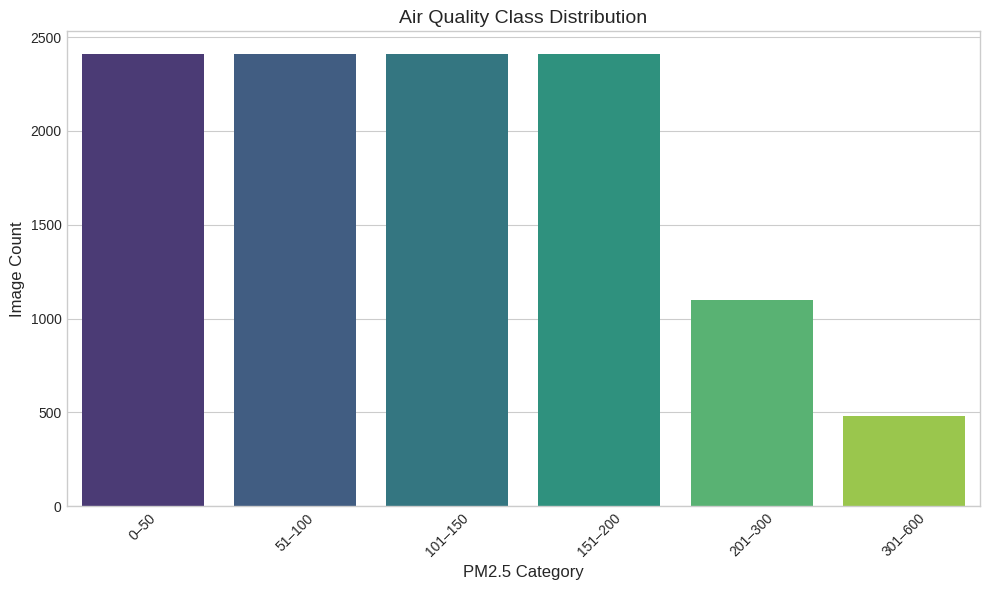

In [23]:
plt.style.use('seaborn-v0_8-whitegrid')

# 1. Figure: Class Balance (Task 2.1.vi)
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='pm25_bin', order=df['pm25_bin'].value_counts().index, palette='viridis')
plt.title('Air Quality Class Distribution', fontsize=14)
plt.xlabel('PM2.5 Category', fontsize=12)
plt.ylabel('Image Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('class_balance.png', dpi=300)
print("Saved: class_balance.png")

# 2. Figure: Aspect Ratio Distribution

Saved: aspect_ratio_dist.png


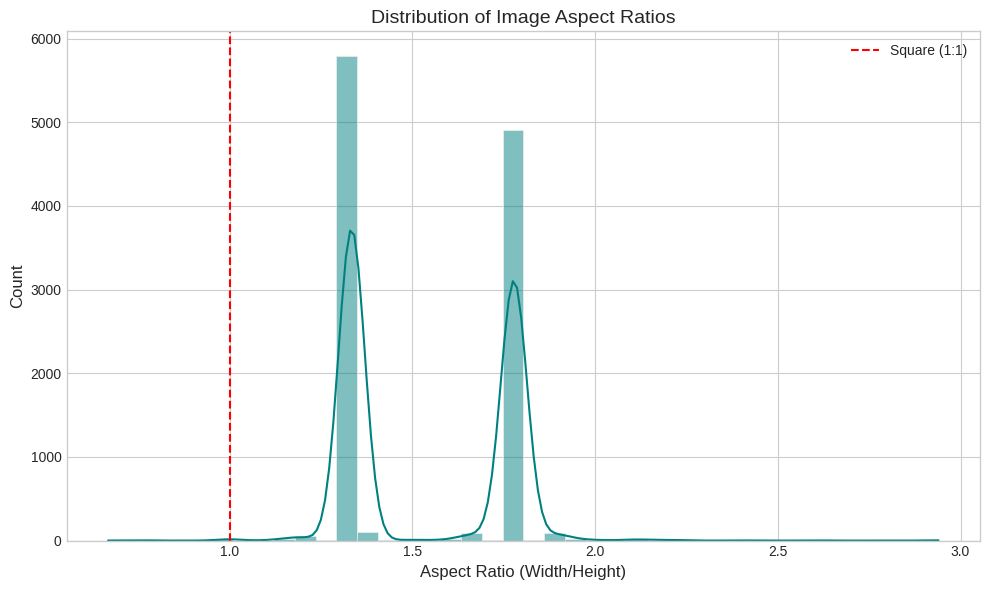

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(full_res_df['aspect_ratio'], bins=40, kde=True, color='teal')
plt.axvline(1.0, color='red', linestyle='--', label='Square (1:1)')
plt.title('Distribution of Image Aspect Ratios', fontsize=14)
plt.xlabel('Aspect Ratio (Width/Height)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('aspect_ratio_dist.png', dpi=300)
print("Saved: aspect_ratio_dist.png")

# Figure: Color Histograms

Saved: color_analysis.png


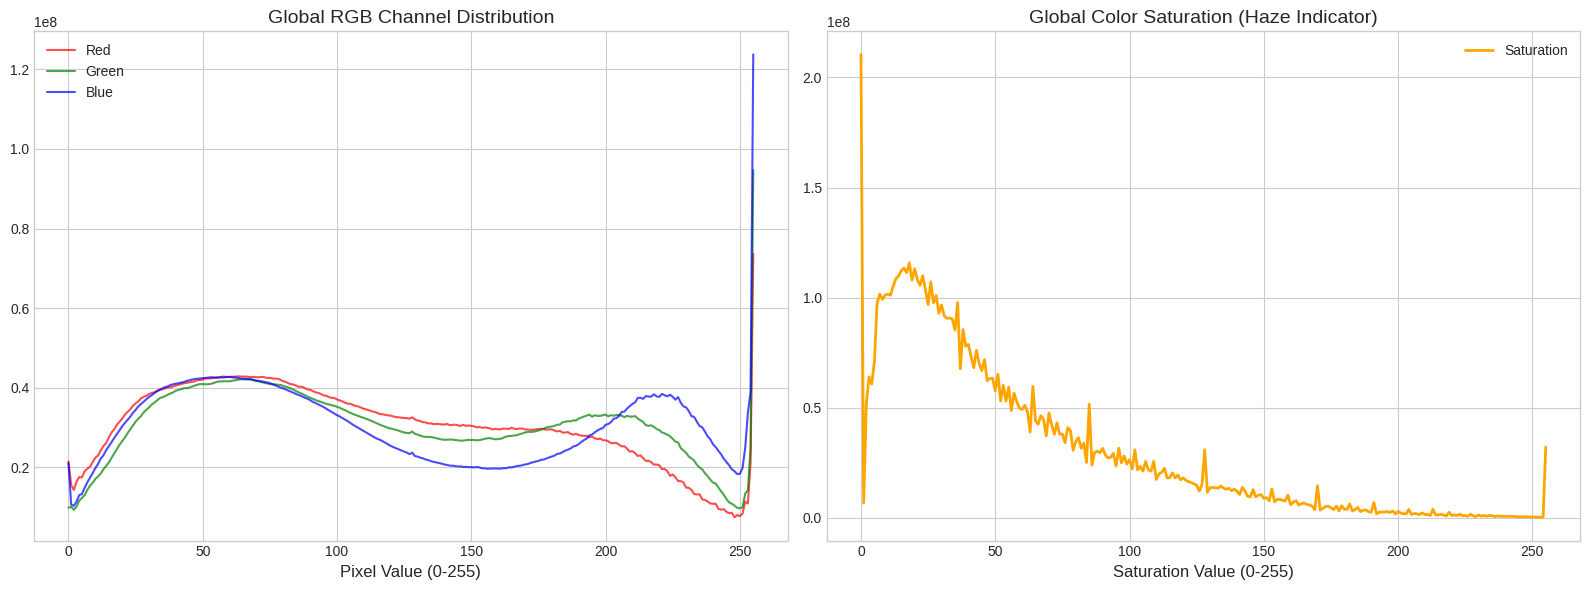

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
# RGB
ax1.plot(rgb_hists[0], color='red', alpha=0.7, label='Red')
ax1.plot(rgb_hists[1], color='green', alpha=0.7, label='Green')
ax1.plot(rgb_hists[2], color='blue', alpha=0.7, label='Blue')
ax1.set_title('Global RGB Channel Distribution', fontsize=14)
ax1.set_xlabel('Pixel Value (0-255)')
ax1.legend()
# HSV Saturation
ax2.plot(hsv_hists[1], color='orange', linewidth=2, label='Saturation')
ax2.set_title('Global Color Saturation (Haze Indicator)', fontsize=14)
ax2.set_xlabel('Saturation Value (0-255)')
ax2.legend()
plt.tight_layout()
plt.savefig('color_analysis.png', dpi=300)
print("Saved: color_analysis.png")

# Figure: Sharpness by Class

/tmp/ipykernel_55/3334058762.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=full_stats_df, x='class', y='sharpness', palette='magma')


Saved: sharpness_boxplot.png


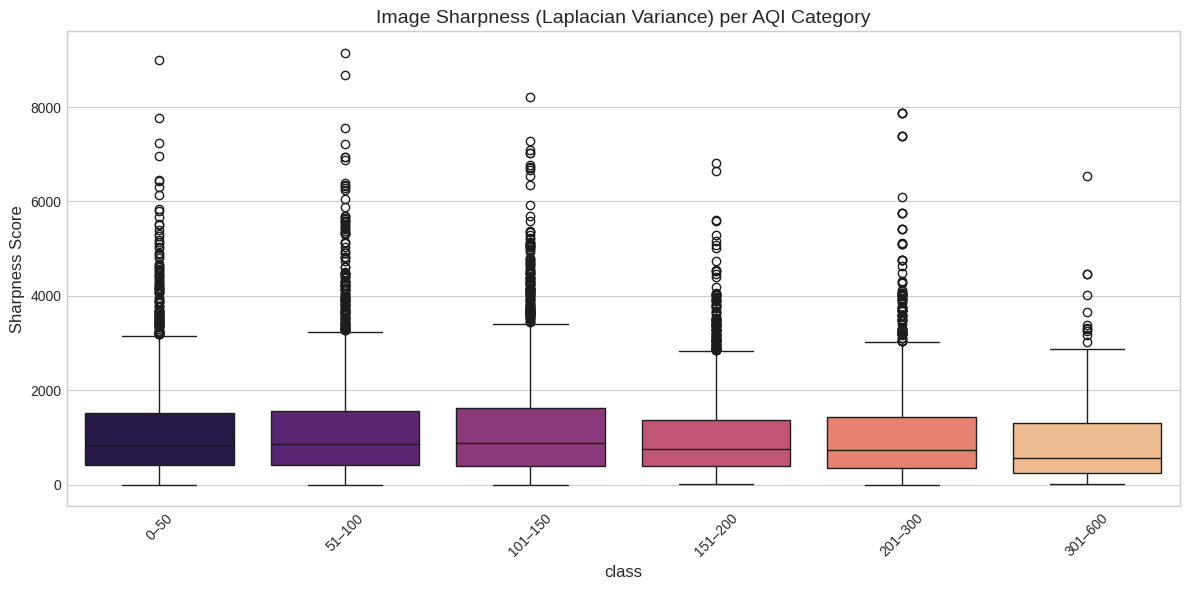

In [26]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=full_stats_df, x='class', y='sharpness', palette='magma')
plt.title('Image Sharpness (Laplacian Variance) per AQI Category', fontsize=14)
plt.ylabel('Sharpness Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('sharpness_boxplot.png', dpi=300)
print("Saved: sharpness_boxplot.png")